# Processing dataset

In [22]:
import sys
import asyncio

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor

# Dataset da https://data.world/data-society/used-cars-data
original_df = pd.read_csv('autos.csv')
target_column = "price"


def preprocessing(df, discretize=False):
    df = df.copy()
    
    # Drop colonne inutili
    df = df.drop(columns=['dateCrawled', 'dateCreated', 'nrOfPictures', 'lastSeen', 'postalCode', 'seller', 'offerType', 'abtest', 'monthOfRegistration'])
    
    # Drop nome e model in quanto creerebbero troppe colonne con il one-hot encoding, inoltre esiste la colonna brand
    df = df.drop(columns=['name', 'model'])
    
    # gearbox in boolen e rinominazione
    df['gearbox'] = df['gearbox'].map({'manuell': False, 'automatik': True})
    df = df.rename(columns={'gearbox': 'gearboxAutomatic'})
    
    # notRepairedDamage in boolean
    df['notRepairedDamage'] = df['notRepairedDamage'].map({'ja': True, 'nein': False})
    
    df = df.rename(columns={"powerPS": "powerHP"})
    
    # mantieni solo brand che hanno più dell'1.5% delle voci
    value_counts = df["brand"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.015 * len(df)].index
    df = df[df["brand"].isin(values_to_keep)]


    df['vehicleType'] = df['vehicleType'].replace('andere', 'other')
    df['vehicleType'] = df['vehicleType'].replace('kleinwagen', 'citycar')
    df['vehicleType'] = df['vehicleType'].replace('kombi', 'stationwagon')
    df['vehicleType'] = df['vehicleType'].replace('andere', 'other')

    # mantieni solo vehicleType che hanno più dell'3% delle voci
    value_counts = df["vehicleType"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.03 * len(df)].index
    df = df[df["vehicleType"].isin(values_to_keep)]
    
    # mantieni solo fuelType che hanno più dell'1% delle voci
    value_counts = df["fuelType"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.01 * len(df)].index
    df = df[df["fuelType"].isin(values_to_keep)]
    
    # In quanto solo diesel e benzina hanno un numero significativo di voci, rendiamo la colonna booleana
    df['fuelType'] = df['fuelType'].map({'diesel': True, 'benzin': False})
    df = df.rename(columns={'fuelType': 'fuelTypeDiesel'})
    
    # Elimina valori eccessivi nel prezzo
    df = df[df['price'] < 1000000]
    df = df[df['price'] > 100]
    
    

    # Algoritmi necessitano di valori non nulli
    df = df.dropna()
    df.to_csv('preprocessed_data.csv', index=False)

    if not discretize:
        # Fai one-hot encoding delle colonne categoriche
        df = pd.get_dummies(df, columns=['vehicleType', 'brand'])
    else:
        # Discretizzazione delle colonne continue
        for c in ["powerHP", "yearOfRegistration", "price"]:  # kilometer ha pochi valori
            df[c] = pd.qcut(df[c], q=10, labels=False)
        
        df.to_csv('discretized_data.csv', index=False)
        
    
    # Prendi k voci a caso
    df = df.sample(27000)

    X_set = df.drop(target_column, axis=1)
    y_set = df[target_column]


    return df, X_set, y_set


preprocessed_df, X, y = preprocessing(original_df)


# Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
# In python gli alberi di decisione non supportano feature categoriche


print(preprocessed_df)

# y_extracted = preprocessed_df[[target_column]]
# scaler = MinMaxScaler()
# y = scaler.fit_transform(y_extracted).ravel()

discr_df, X_discr, y_discr = preprocessing(original_df, discretize=True)
...

        price  yearOfRegistration gearboxAutomatic  powerHP  kilometer  \
108292  12999                2009             True      170     150000   
325230    500                2001            False       75      80000   
23564     120                1997            False       60     150000   
175098   3500                1999            False      150     150000   
53450    2990                2002            False       75     150000   
...       ...                 ...              ...      ...        ...   
189331  56900                2012             True      306      30000   
199025   7500                2005            False      163     150000   
118769   1550                2004            False       75     125000   
121908   9999                2006            False      265     150000   
197982   7900                2005             True      224     150000   

       fuelTypeDiesel notRepairedDamage  vehicleType_bus  vehicleType_cabrio  \
108292           True          

Ellipsis

# Apprendimento supervisionato

In [23]:
def calculate_baseline_score(df, target_column, scoring):
    # Per vedere se la loss del modello è migliore di quella che si potrebbe ottenere con una predizione banale, come media o mediana
    if scoring == "neg_root_mean_squared_error":
        baseline_prediction = df[target_column].mean()
        baseline_error = - (df[target_column] - baseline_prediction).pow(2).mean() ** 0.5
    elif scoring == "neg_mean_absolute_error":
        baseline_prediction = df[target_column].median()
        baseline_error = - (df[target_column] - baseline_prediction).abs().mean()
    else:
        raise ValueError("Invalid scoring metric")

    return baseline_error


def search_hyperparameters(model, param_grid, X, y, cv, scoring):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)

    # scores = cross_val_score(ctf, X, y, cv=cv, scoring=scoring)
    # grid_search.fit implicitamente usa cross_val_score e quindi non abbiamo bisogno di ripeterlo
    # Gli score ottenuti usando cross_val_score con i migliori iperparametri sono già restituiti da grid_search
    scores = grid_search.best_score_
    params = grid_search.best_params_
    print("Scores:", scores)
    print("Best params:", params)

    model_results = {"scores": scores, "params": params, "model": grid_search.best_estimator_}

    return model_results


def performance_comparison(train_results):
    for scoring_metric in train_results:        
        models = list(train_results[scoring_metric].keys())
        if not train_results[scoring_metric][models[0]]:
            continue
        scores = [train_results[scoring_metric][model]["scores"] for model in train_results[scoring_metric]]

        # Extract mean scores for plotting
        mean_scores = [np.mean(score) for score in scores]

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(models, mean_scores, color=['blue', 'green', 'red'])
        plt.gca().invert_yaxis()

        ax.set_title(f'Performance Comparison ({scoring_metric})')
        ax.set_xlabel('Models')
        ax.set_ylabel('Mean Score')

        # Adjust y-axis limits to better visualize negative scores
        # ymin = max(mean_scores) * 1.1 if min(mean_scores) < 0 else max(mean_scores) * 0.9
        # ymax = min(mean_scores) * 1.1 if max(mean_scores) > 0 else min(mean_scores) * 0.9
        # ax.set_ylim([ymin, ymax])
        ax.grid(True)

        # Adding text for each bar
        # for i, v in enumerate(mean_scores):
        #     if v < 0:
        #         ax.text(i, v - (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='top')
        #     else:
        #         ax.text(i, v + (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='bottom')

        plt.savefig(f"performance_comparison_{scoring_metric}.png")


def show_learning_curves(search_results, X_set, y_set, cv):
    # Initialize an empty DataFrame
    variance_df = pd.DataFrame(columns=['Model', 'Train Score Variance', 'Test Score Variance'])

    for scoring_metric in search_results:
        for model_name in search_results[scoring_metric]:
            title = f"Learning Curve ({model_name}, {scoring_metric})"
            estimator = search_results[scoring_metric][model_name].get("model", None)
            if estimator is None:
                continue

            plt.figure(figsize=(10, 6))
            plt.title(title)
            plt.xlabel("Training examples")
            plt.ylabel(scoring_metric)

            train_sizes, train_scores, test_scores = learning_curve(
                estimator, X_set, y_set, cv=cv, n_jobs=None, train_sizes=np.linspace(0.2, 1.0, 5), scoring=scoring_metric
            )

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.grid()

            plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
            plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
            plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
            plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

            plt.legend(loc="best")
            plt.savefig(f"{title}.png")
            print(f"Saved {title}.png")

            # Calculate the variance of the train and test scores
            train_score_variance = np.var(train_scores, axis=1)[-1]
            test_score_variance = np.var(test_scores, axis=1)[-1]

            # Create a DataFrame with a single row of data
            variance_data = pd.DataFrame([{
                'Model': title,
                'Train Score Std dev': train_scores_std[-1],
                'Test Score Std dev': test_scores_std[-1],
                'Train Score Variance': train_score_variance,
                'Test Score Variance': test_score_variance,
                'Ratio': test_score_variance / train_score_variance
            }])

            # Append the new data to the DataFrame
            variance_df = pd.concat([variance_df, variance_data], ignore_index=True)
            print(variance_df.head())

    # Print the DataFrame
    return variance_df


# Scelte due metriche di scoring
scorings = [
    # 'neg_root_mean_squared_error', 
    'neg_mean_absolute_error'
]


## Training dei modelli

In [24]:
results = {s: {"decision_tree": {},
               "random_forest": {},
               "gradient_boosting": {}} for s in scorings}

dtr_param_grid = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    # 'splitter': ['best'],
    # 'max_depth': [None, 10, 20],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

rfr_param_grid = {
    # 'n_estimators': [100, 200],
    # 'criterion': ["squared_error", "friedman_mse", "poisson"],
    'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

gbr_param_grid = {
    # 'n_estimators': [100, 200],
    # 'loss': ['squared_error', 'huber', 'quantile'],
    'learning_rate': [0.01, 0.1, 0.5],
    # 'criterion': ['friedman_mse', 'squared_error'],
    # 'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
    # 'subsample': [0.1, 0.5, 1.0],
}

# Perform 5-fold cross-validation, repeated 3 times, and print the average score
cv = RepeatedKFold(n_splits=5, n_repeats=1)
# TODO fonty per la grid search fa solo cv=5 che come se fosse n_repeats=1

# Addestrare ogni modello per ogni metrica di scoring
for scoring in scorings:
    baseline_score = calculate_baseline_score(original_df, target_column, scoring)
    print(f"Baseline for scoring metric {scoring}: ", baseline_score)

    dtr = DecisionTreeRegressor()
    print(f"Training decision tree with scoring metric {scoring}")
    results[scoring]["decision_tree"] = search_hyperparameters(dtr, dtr_param_grid, X, y, cv, scoring)

    rfr = RandomForestRegressor()
    print(f"Training random forest with scoring metric {scoring}")
    results[scoring]["random_forest"] = search_hyperparameters(rfr, rfr_param_grid, X, y, cv, scoring)

    gbr = GradientBoostingRegressor()
    print(f"Training gradient boosted model with scoring metric {scoring}")
    results[scoring]["gradient_boosting"] = search_hyperparameters(gbr, gbr_param_grid, X, y, cv, scoring)

print(results)


Baseline for scoring metric neg_mean_absolute_error:  -16051.040010443357
Training decision tree with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Scores: -1762.037739921383
Best params: {'criterion': 'poisson'}
Training random forest with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Scores: -1452.855296896107
Best params: {'max_depth': None}
Training gradient boosted model with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Scores: -1535.335526379528
Best params: {'learning_rate': 0.5}
{'neg_mean_absolute_error': {'decision_tree': {'scores': -1762.037739921383, 'params': {'criterion': 'poisson'}, 'model': DecisionTreeRegressor(criterion='poisson')}, 'random_forest': {'scores': -1452.855296896107, 'params': {'max_depth': None}, 'model': RandomForestRegressor()}, 'gradient_boosting': {'scores': -1535.335526379528, 'params': {'lea

## Performance Comparison

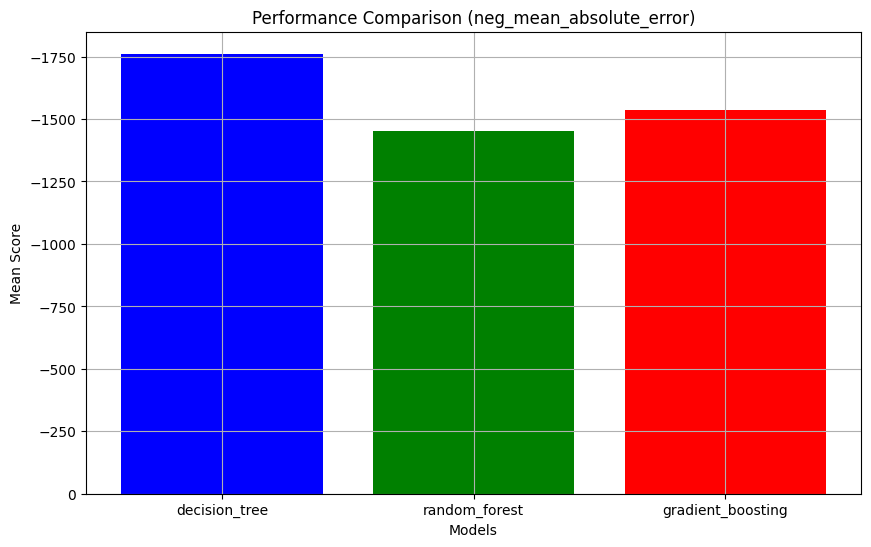

In [25]:
performance_comparison(results)

## Learning Curve

Saved Learning Curve (decision_tree, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (decision_tree, neg_mean_absolu...             17.906363   

   Test Score Variance  Train Score Std dev  Test Score Std dev       Ratio  
0          3793.044627             4.231591           61.587699  211.826635  


C:\Users\Valerio\AppData\Local\Temp\ipykernel_2244\715442601.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat([variance_df, variance_data], ignore_index=True)


Saved Learning Curve (random_forest, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (decision_tree, neg_mean_absolu...             17.906363   
1  Learning Curve (random_forest, neg_mean_absolu...             59.868051   

   Test Score Variance  Train Score Std dev  Test Score Std dev       Ratio  
0          3793.044627             4.231591           61.587699  211.826635  
1          1605.375426             7.737445           40.067136   26.815228  
Saved Learning Curve (gradient_boosting, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (decision_tree, neg_mean_absolu...             17.906363   
1  Learning Curve (random_forest, neg_mean_absolu...             59.868051   
2  Learning Curve (gradient_boosting, neg_mean_ab...            226.382251   

   Test Score Variance  Train Score Std dev  Test Score Std dev       Ratio  
0   

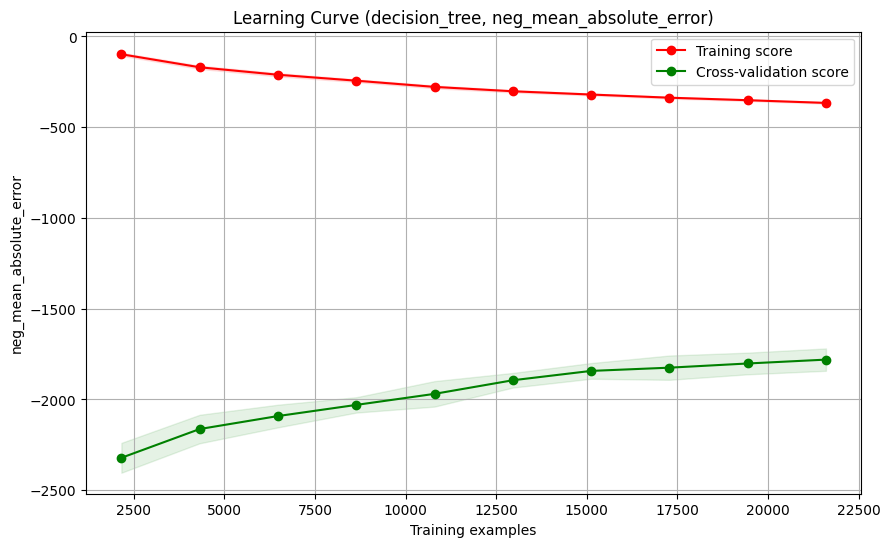

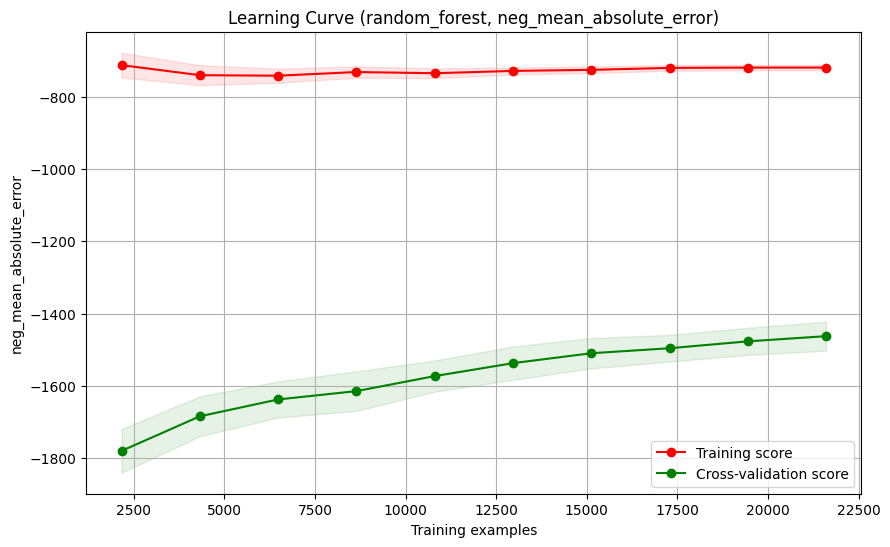

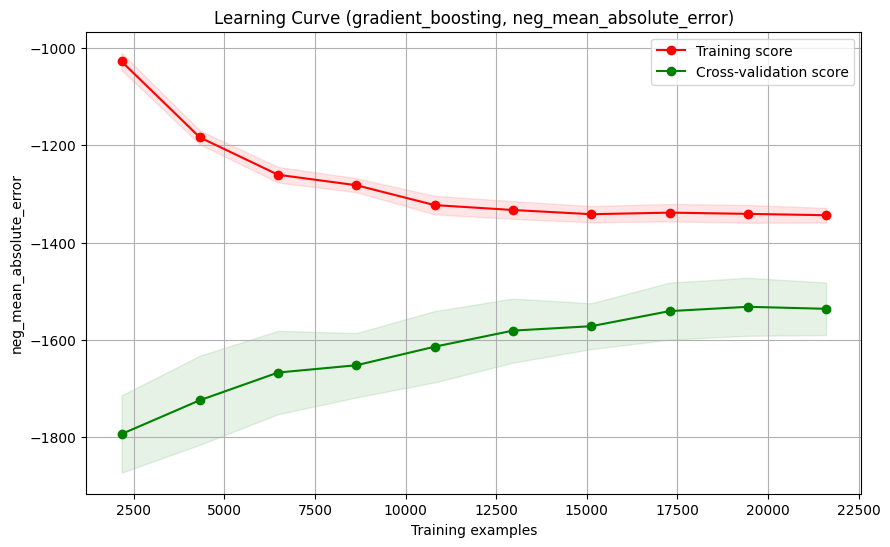

In [27]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
var_df = show_learning_curves(results, X, y, cv)
print(var_df.head())

# Overfitting
Dunque si riprova con regressione lineare, lasso e ridge

In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge

results_linear = {s: {"linear_regression": {},
                        "lasso": {},
                        "ridge": {},
                        "bayesian_ridge": {}} for s in scorings}

lr_param_grid = {
    'fit_intercept': [True, False],
}

lasso_param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    # 'max_iter': [1000, 10000, 50000],
    'selection': ['cyclic', 'random'],
}

ridge_param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    # 'max_iter': [1000, 10000, 50000],
}

br_param_grid = {
    # 'n_iter': [100, 300, 500],
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4],
}

cv = RepeatedKFold(n_splits=5, n_repeats=1)

for scoring in scorings[:1]:
    lr = LinearRegression()
    print(f"Training linear regression with scoring metric {scoring}")
    results_linear[scoring]["linear_regression"] = search_hyperparameters(lr, lr_param_grid, X, y, cv, scoring)

    # lasso = Lasso()
    # print(f"Training lasso with scoring metric {scoring}")
    # results_linear[scoring]["lasso"] = search_hyperparameters(lasso, lasso_param_grid, X, y, cv, scoring)
    # 
    # ridge = Ridge()
    # print(f"Training ridge with scoring metric {scoring}")
    # results_linear[scoring]["ridge"] = search_hyperparameters(ridge, ridge_param_grid, X, y, cv, scoring)
    
    br = BayesianRidge()
    print(f"Training bayesian ridge with scoring metric {scoring}")
    results_linear[scoring]["bayesian_ridge"] = search_hyperparameters(br, br_param_grid, X, y, cv, scoring)
    
print(results_linear)


Training linear regression with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Scores: -3100.6694210433575
Best params: {'fit_intercept': False}
Training lasso with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Scores: -3081.4273464802272
Best params: {'alpha': 10.0, 'fit_intercept': True, 'selection': 'random'}
Training ridge with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Scores: -3099.211530491545
Best params: {'alpha': 10.0, 'fit_intercept': True}
Training bayesian ridge with scoring metric neg_mean_absolute_error
Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: 

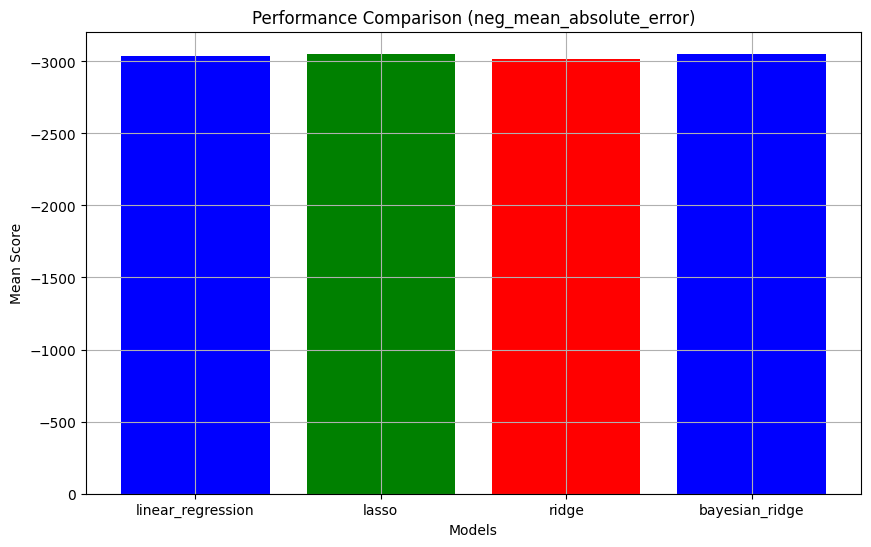

In [8]:
performance_comparison(results_linear)

Saved Learning Curve (linear_regression, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (linear_regression, neg_mean_ab...           5603.126933   

   Test Score Variance  Train Score Std dev  Test Score Std dev     Ratio  
0         13400.840334            74.854038          115.761999  2.391672  


C:\Users\Valerio\AppData\Local\Temp\ipykernel_42136\715442601.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat([variance_df, variance_data], ignore_index=True)


Saved Learning Curve (lasso, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (linear_regression, neg_mean_ab...           5603.126933   
1    Learning Curve (lasso, neg_mean_absolute_error)           6365.111353   

   Test Score Variance  Train Score Std dev  Test Score Std dev     Ratio  
0         13400.840334            74.854038          115.761999  2.391672  
1          9386.873157            79.781648           96.885877  1.474738  
Saved Learning Curve (ridge, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (linear_regression, neg_mean_ab...           5603.126933   
1    Learning Curve (lasso, neg_mean_absolute_error)           6365.111353   
2    Learning Curve (ridge, neg_mean_absolute_error)           5270.791794   

   Test Score Variance  Train Score Std dev  Test Score Std dev     Ratio  
0         13400.840334          

C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_bayes.py:54: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_bayes.py:54: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_bayes.py:54: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_bayes.py:54: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_bayes.py:54: FutureWarning:

Saved Learning Curve (bayesian_ridge, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (linear_regression, neg_mean_ab...           5603.126933   
1    Learning Curve (lasso, neg_mean_absolute_error)           6365.111353   
2    Learning Curve (ridge, neg_mean_absolute_error)           5270.791794   
3  Learning Curve (bayesian_ridge, neg_mean_absol...           4397.090125   

   Test Score Variance  Train Score Std dev  Test Score Std dev     Ratio  
0         13400.840334            74.854038          115.761999  2.391672  
1          9386.873157            79.781648           96.885877  1.474738  
2         10857.166444            72.600219          104.197728  2.059874  
3          3618.259270            66.310558           60.151968  0.822876  


,Model,Train Score Variance,Test Score Variance,Train Score Std dev,Test Score Std dev,Ratio
0,"Learning Curve (linear_regression, neg_mean_ab...",5603.126933,13400.840334,74.854038,115.761999,2.391672
1,"Learning Curve (lasso, neg_mean_absolute_error)",6365.111353,9386.873157,79.781648,96.885877,1.474738
2,"Learning Curve (ridge, neg_mean_absolute_error)",5270.791794,10857.166444,72.600219,104.197728,2.059874
3,"Learning Curve (bayesian_ridge, neg_mean_absol...",4397.090125,3618.259270,66.310558,60.151968,0.822876


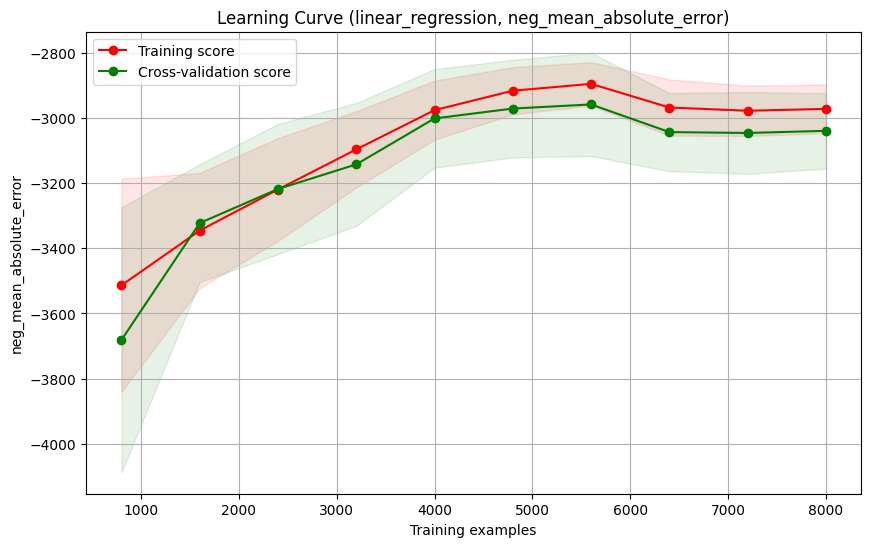

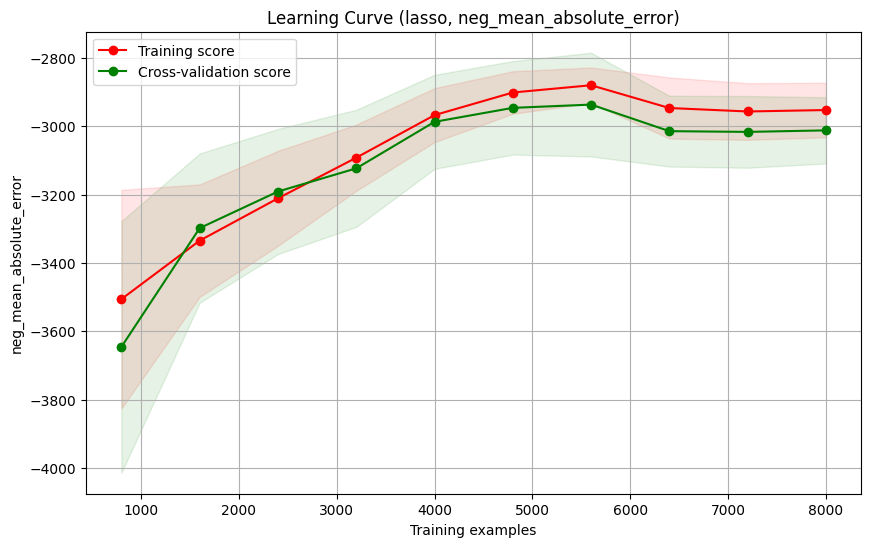

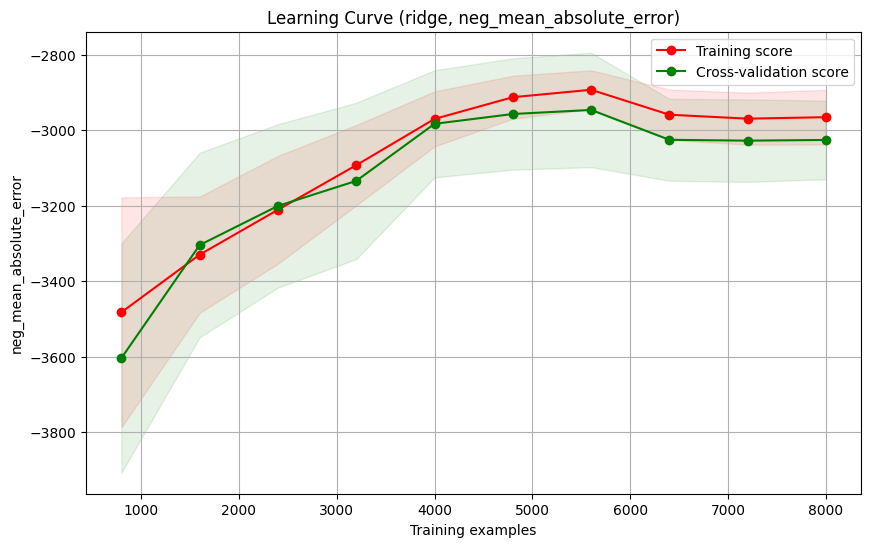

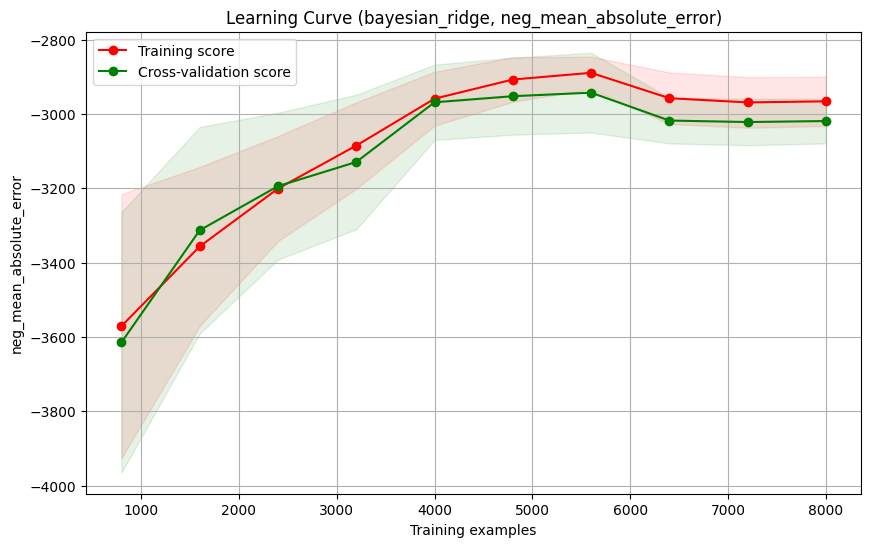

In [9]:
cv = RepeatedKFold(n_splits=5, n_repeats=3)
show_learning_curves(results_linear, X, y, cv)

# Riassunto documentazione

In questo notebook abbiamo eseguito un'analisi dei dati su un dataset di auto usate, con l'obiettivo di prevedere il prezzo di vendita di un'auto in base alle sue caratteristiche. Abbiamo eseguito un'analisi esplorativa dei dati, effettuato il preprocessing dei dati, addestrato modelli di apprendimento supervisionato e non supervisionato, e ridotto la dimensionalità dei dati utilizzando la PCA.

Abbiamo confrontato le prestazioni dei modelli addestrati utilizzando diverse metriche di scoring e visualizzato le curve di apprendimento per valutare il trade-off tra bias e varianza. Infine, abbiamo esaminato l'impatto della riduzione della dimensionalità sui modelli di apprendimento supervisionato.

I risultati ottenuti mostrano che i modelli di Random Forest e Gradient Boosted Trees hanno prestazioni migliori rispetto al Decision Tree, con il Gradient Boosted Trees che fornisce i risultati migliori in termini di metriche di scoring. Inoltre, la riduzione della dimensionalità tramite PCA ha portato a una riduzione delle prestazioni dei modelli di apprendimento supervisionato, con un aumento della varianza e una diminuzione della capacità predittiva.

In futuro, potremmo esplorare ulteriori tecniche di preprocessing dei dati, addestrare modelli più complessi e ottimizzare ulteriormente gli iperparametri per migliorare le prestazioni dei modelli. Inoltre, potremmo esplorare altre tecniche di riduzione della dimensionalità e valutare il loro impatto sui modelli di apprendimento supervisionato.

# Da albero a prolog

In [29]:
from sklearn.tree import _tree


def extract_tree_structure(tree, feature_names):
    tree_ = tree.tree_
    feature_names = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if ({name} <= {threshold:.2f}) {{")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}}} else {{")
            recurse(tree_.children_right[node], depth + 1)
            print(f"{indent}}}")
        else:
            print(f"{indent}return {tree_.value[node]}")

    recurse(0, 0)


# Extract tree structure
def tree_to_prolog(regressor, node_id=0, parent_id=None):
    base_code = """
% Prende in input una lista di features e salva man mano il prezzo piu alto
macchina_piu_costosa([Features|AltreMacchine], Macchina, Prezzo) :-
    predirre_prezzo(Features, PrezzoCorrente),
    macchina_piu_costosa(AltreMacchine, MaxMacchina, MaxPrezzo),
    (PrezzoCorrente > MaxPrezzo ->
     Macchina = Features, Prezzo = PrezzoCorrente
     ;
     Macchina = MaxMacchina, Prezzo = MaxPrezzo).

macchina_piu_costosa([], [], 0).


prezzo_conveniente(Features, PrezzoProposto) :-
    predirre_prezzo(Features, PrezzoPredetto),
    PrezzoProposto < PrezzoPredetto.
    

predirre_prezzo(Features, Prezzo) :-
    traverse_tree(0, Features, Prezzo).

% Passo base
percorri_albero(NodeID, _, Predizione) :-
    leaf(NodeID, Predizione).

% Passo ricorsivo
percorri_albero(NodeID, Features, Predizione) :-
    node(NodeID, FeatureIndex, Threshold, LeftChild, RightChild, _),
    nth0(FeatureIndex, Features, FeatureValue),
    (FeatureValue =< Threshold ->
        traverse_tree(LeftChild, Features, Predizione)
    ;
        traverse_tree(RightChild, Features, Predizione)
    ).

"""

    result = ""
    # Check if it's a leaf node
    if regressor.tree_.children_left[node_id] == -1:
        # Leaf node
        value = regressor.tree_.value[node_id][0, 0]  # Assuming single target value
        result += f"leaf({node_id}, {value}).\n"
    else:
        # Decision node
        feature = regressor.tree_.feature[node_id]
        threshold = regressor.tree_.threshold[node_id]
        left_child = regressor.tree_.children_left[node_id]
        right_child = regressor.tree_.children_right[node_id]
        result += f"node({node_id}, {feature}, {threshold}, {left_child}, {right_child}, _).\n"
        # Recursively add left and right children
        result += tree_to_prolog(regressor, left_child, node_id)
        result += tree_to_prolog(regressor, right_child, node_id)
    result = "\n".join(sorted(result.split("\n")))
    if parent_id is None:
        return base_code + result
    return result

dtree = results["neg_mean_absolute_error"]["decision_tree"]["model"]
pl = tree_to_prolog(dtree)
with open("decision_tree.pl", "w", encoding="utf-8") as f:
    f.write(pl)


In [4]:
from pyswip import Prolog

prolog = Prolog()
prolog.consult("decision_tree.pl")

features = list(X.iloc[0].values.astype(float))

print(features)

prolog_pred = prolog.query(f"predirre_prezzo({features}, Prediction)")
print(f"Prolog prediction: {list(prolog_pred)}")

dtree_pred = dtree.predict([X.iloc[0].values])
print(f"Decision tree prediction: {dtree_pred}")


a
a
a
b
[2006.0, 0.0, 150.0, 150000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Prolog prediction: [{'Prediction': 7575.0}]


NameError: name 'dtree' is not defined

## Stima del prezzo per una macchina

In [37]:
import pandas
from pyswip import Prolog

prolog = Prolog()
prolog.consult("conveniente.pl")

predirre_prezzo = prolog.query("predirre_prezzo([coupe,2011,false,190,125000,true,audi,true], Prezzo).")
print(list(predirre_prezzo))

convieniente = prolog.query("prezzo_conveniente([coupe,2011,false,190,125000,true,audi,true], 10000).")
print(bool(list(convieniente)))

macchina_piu_costosa = prolog.query(
    "macchina_piu_costosa([[coupe,2011,false,190,125000,true,audi,true],"
                          "[coupe,2015,false,190,125000,true,audi,true]], Macchina, Prezzo)."
)
print(f"Macchina più costosa: {list(macchina_piu_costosa)}")

dataset_macchine = pandas.read_csv("preprocessed_data.csv")
dataset_macchine = dataset_macchine.drop(columns=["price"])
lista_macchine = dataset_macchine.values.tolist()
lista_macchine_str = str(lista_macchine).replace("True", "true").replace("False", "false").replace("'", "")
macchina_piu_costosa2 = prolog.query(f"macchina_piu_costosa({lista_macchine_str}, Macchina, Prezzo).")
print(f"Macchina più costosa di tutto il dataset: {list(macchina_piu_costosa2)}")


[{'Prezzo': 16450.0}]
True
Macchina più costosa: [{'Macchina': ['coupe', 2015, 'false', 190, 125000, 'true', 'audi', 'true'], 'Prezzo': 17250.0}]
Macchina più costosa di tutto il dataset: [{'Macchina': ['coupe', 1999, 'true', 20000, 150000, 'false', 'mercedes_benz', 'false'], 'Prezzo': 413000.0}]


# Apprendimento Bayesiano

In [7]:
from pgmpy.estimators import HillClimbSearch, BicScore

# Utilizzo di HillClimbSearch per apprendere la struttura
hc = HillClimbSearch(discr_df)
best_model = hc.estimate()

print(best_model.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

[('price', 'yearOfRegistration'), ('vehicleType', 'price'), ('vehicleType', 'powerHP'), ('vehicleType', 'yearOfRegistration'), ('gearboxAutomatic', 'price'), ('gearboxAutomatic', 'powerHP'), ('gearboxAutomatic', 'yearOfRegistration'), ('gearboxAutomatic', 'vehicleType'), ('gearboxAutomatic', 'brand'), ('gearboxAutomatic', 'fuelTypeDiesel'), ('powerHP', 'price'), ('powerHP', 'yearOfRegistration'), ('kilometer', 'price'), ('kilometer', 'powerHP'), ('kilometer', 'yearOfRegistration'), ('kilometer', 'vehicleType'), ('fuelTypeDiesel', 'price'), ('fuelTypeDiesel', 'powerHP'), ('fuelTypeDiesel', 'yearOfRegistration'), ('fuelTypeDiesel', 'vehicleType'), ('brand', 'price'), ('brand', 'powerHP'), ('brand', 'yearOfRegistration'), ('brand', 'vehicleType'), ('brand', 'fuelTypeDiesel'), ('notRepairedDamage', 'price'), ('notRepairedDamage', 'powerHP'), ('notRepairedDamage', 'yearOfRegistration'), ('notRepairedDamage', 'vehicleType')]


In [8]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

# Creare il modello bayesiano con la struttura appresa
model = BayesianNetwork(best_model.edges())

# Apprendere le CPDs dai dati
model.fit(discr_df, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=10)

# Verifica del modello
assert model.check_model()


In [19]:
from pgmpy.inference import VariableElimination

# Creare un oggetto di inferenza
inference = VariableElimination(model)

# Funzione per fare predizioni basate sulle caratteristiche della macchina
def predict_price(evidence):
    query_result = inference.map_query(variables=['price'], evidence=evidence)
    return query_result['price']

# Esempio di inferenza
evidence_example = dict(X_discr.iloc[4])

predicted_price = predict_price(evidence_example)
print(f'Predicted price category: {predicted_price}')


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Predicted price category: 0
